# 1. 윈도우에서 CVAT 설치 하는법

- 이 링크를 참고해서 오토라벨링을 성공하였다 https://bh-kaizen.tistory.com/19

## 1.1 라이브러리 사전 설치

- CVAT를 설치하기 전, WSL과 도커가 필요하다

## WSL 설치 하는법

1. 명령 프롬포트에서 ```wsl --list --online``` 실행
2. ```wsl.exe --install Ubuntu-22.04``` 실행 -> 윈도우에서 우분투 환경 세팅 완료 될 것이다


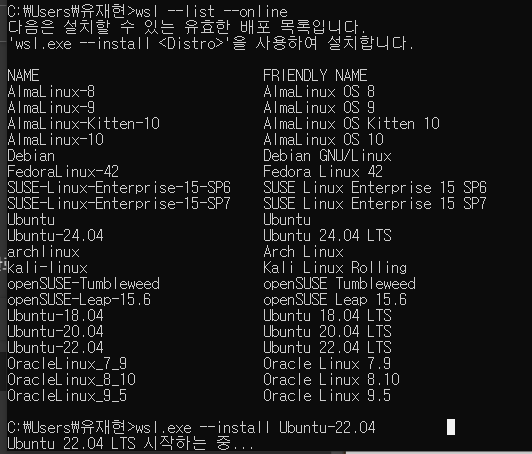

## 도커 설치
- 구글에서 검색해서 도커 설치해도 되고
- or 명령어로 설치도 가능!
- 명령어 최신버전 도커 설치

```
sudo apt-get update
sudo apt-get install ca-certificates curl
sudo install -m 0755 -d /etc/apt/keyrings
sudo curl -fsSL https://download.docker.com/linux/ubuntu/gpg -o /etc/apt/keyrings/docker.asc
sudo chmod a+r /etc/apt/keyrings/docker.asc

# Add the repository to Apt sources:
echo \
  "deb [arch=$(dpkg --print-architecture) signed-by=/etc/apt/keyrings/docker.asc] https://download.docker.com/linux/ubuntu \
  $(. /etc/os-release && echo "$VERSION_CODENAME") stable" | \
  sudo tee /etc/apt/sources.list.d/docker.list > /dev/null
sudo apt-get update

sudo apt-get install docker-ce docker-ce-cli containerd.io docker-buildx-plugin docker-compose-plugin
```

## 1.2 CVAT 설치

- CVAT 깃허브 소스 가져온다
```
git clone https://github.com/cvat-ai/cvat
cd cvat
```
- CVAT에 필요한 이미지들 빌드
```
docker compose up -d
```
- 생성시 기본 포트 번호 값은 `localhost:8080` 이다
- 웹에 접속해서 계정 생성 가능 하지만 명령어도 생성 가능!
```
sudo docker exec -it cvat_server bash -ic 'python3 ~/manage.py createsuperuser'
```
- 새 탭에 로컬호스트 입력하면 CVAT 화면이 뜰 것이다
- 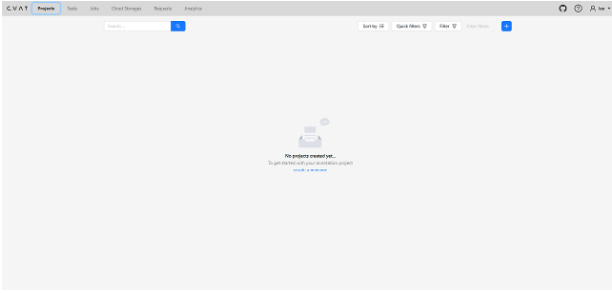


## 2.  CVAT 모델 배포

### 2.1 nuclio 설치

```
CVAT에 학습된 모델을 배포하여 오토 라벨링을 사용하는데 nuclio라는 라이브러리를 사용한다

아무 버전이나 설치하는 것이 아닌, 깃 클론을 통해 가져온 CVAT 소스에 맞는 버젼을 설치해야 한다

필요한 버젼은 CVAT 폴더의 cvat/components/serverless/docker-compose.serverless.yml 에서 확인할 수 있다



아래 이미지처럼 확인해보면 1.13.0 버젼이 필요하다

https://github.com/nuclio/nuclio/releases 에서 맞는 버젼의 파일을 다운받을 수 있지만 파일만 확인하고 아래의 wget 명령어로 다운받는 것이 더 편하다
```

- 필요한 버전은 1.13.0 이므로 아래 명령어로도 다운로드 가능하다
```
wget https://github.com/nuclio/nuclio/releases/download/<version>/nuctl-<version>-linux-amd64
```
- 파일을 CVAT 폴더에 다운받았다면 아래 명령어를 실행한다

해당 명령어들은 다운로드한 nuctl 실행 파일에 실행 권한을 부여하고 심볼릭 링크를 생성하여 nuctl을 시스템 경로에서 실행할 수 있도록 설정한다
```
sudo chmod +x nuctl-<version>-linux-amd64
sudo ln -sf $(pwd)/nuctl-<version>-linux-amd64 /usr/local/bin/nuctl
```
- 정상적으로 동작 시 nuctl --help 명령어를 실행하면 아래와 같이 출력됨

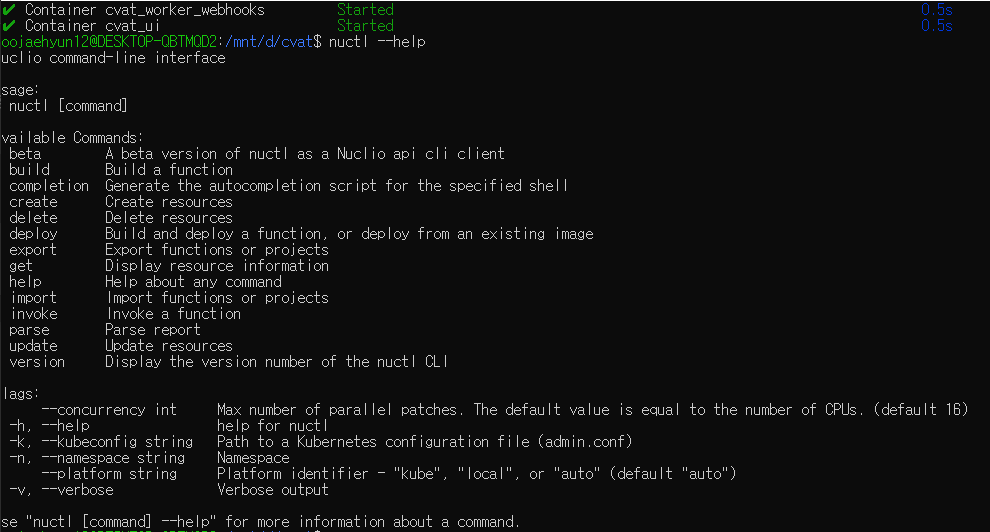

다음으로 아래 명령어를 실행하면 Nuclio 플랫폼을 Docker 컨테이너로 빌드하고 배포하고 CVAT에서 해당 기능을 활성화한다.

이미지 빌드에 시간이 좀 걸린다..
```
docker compose -f docker-compose.yml -f docker-compose.dev.yml -f components/serverless/docker-compose.serverless.yml up -d --build
```

CVAT 웹페이지를 새로고침하면 이전에 없던 Models 카테고리가 생성되었다

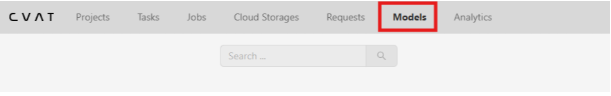

배포한 모델은 nuclio 사이트 주소, localhost:8070 에서도 확인할 수 있다. 아직은 생성한 프로젝트와 배포한 모델이 없어서 default만 존재한다

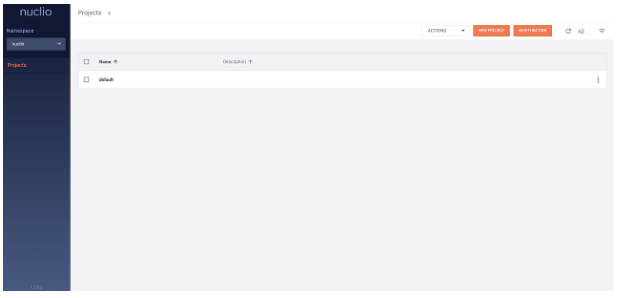

### 2.2 Yolov8 배포

깃허브 소스를 다운받는다
```
git clone https://github.com/kurkurzz/custom-yolov8-auto-annotation-cvat-blueprint.git
```

파일 구성은 아래와 같음

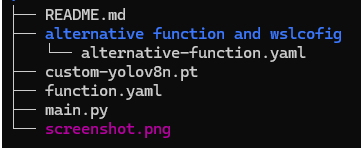

threshold는 파일 중 main.py에서 수정할 수 있다

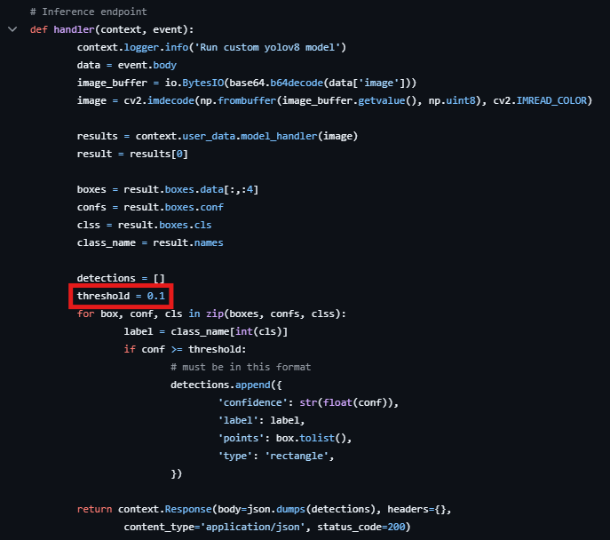

function.yaml 파일 내용 중 spec 부분에 사용할 모델에 맞는 클래스를 설정해야 한다

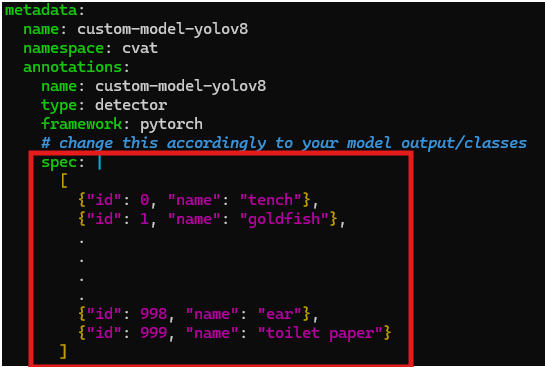

CVAT 폴더에서 아래 명령어 실행. 빌드에 시간이 꽤 걸림...
```
./serverless/deploy_cpu.sh ./custom-yolov8-auto-annotation-cvat-blueprint/
```
빌드 후 배포된 것을 확인할 수 있다. 그럼 이제 CVAT에서 제대로 동작하는지 확인해보자

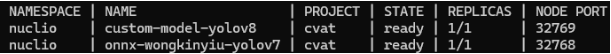

Nuclio 사이트에 추가 완료! 정상적으로 Running 중!

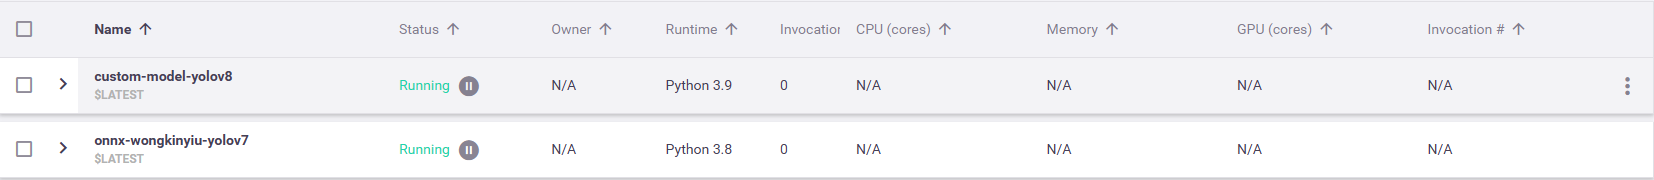

모델에 custom-model-yolov8 추가 완료!

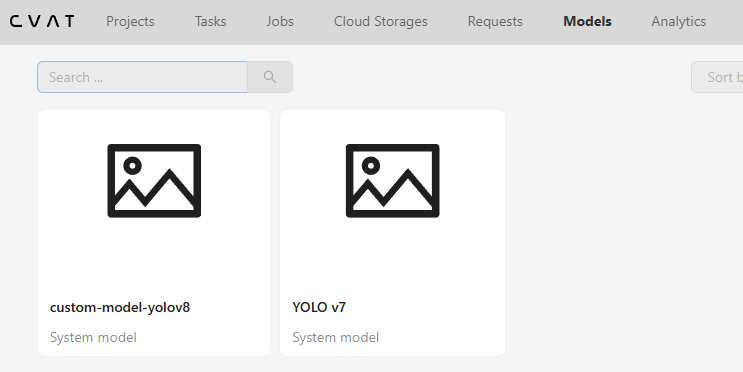

라벨링 하는 방법은?

1. Create a new project 클릭

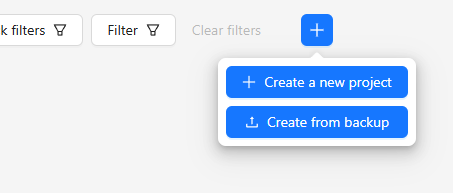

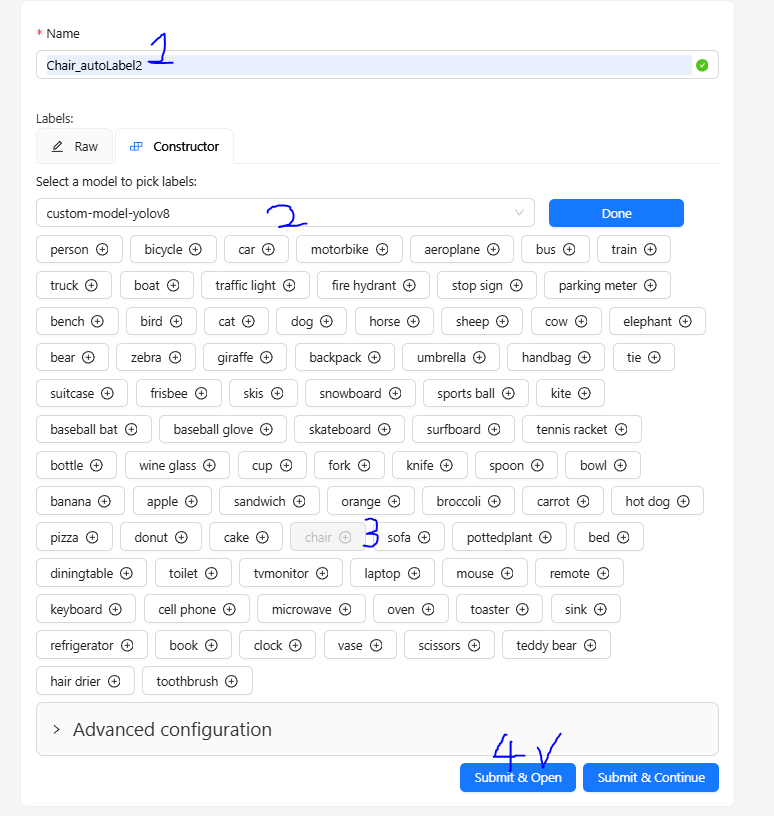

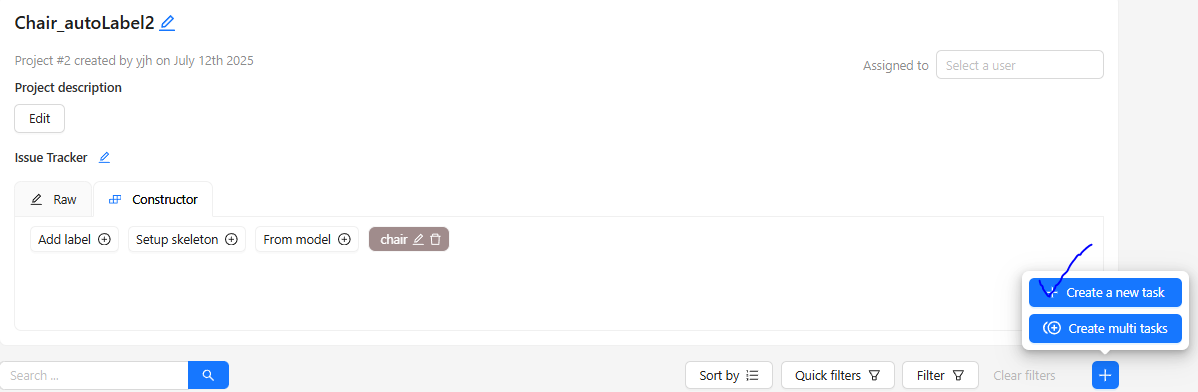

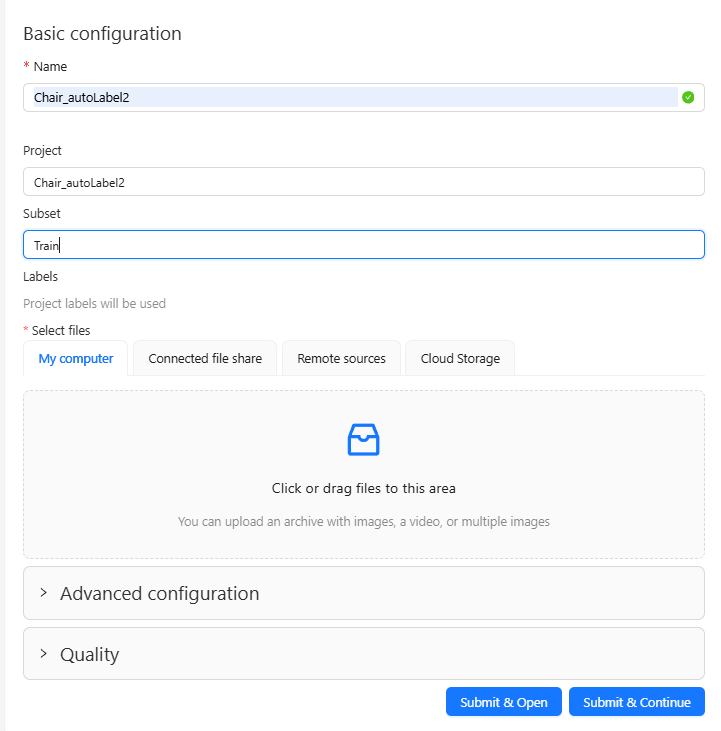

- Advanced Configuration 에서 image quality 100% 로 설정

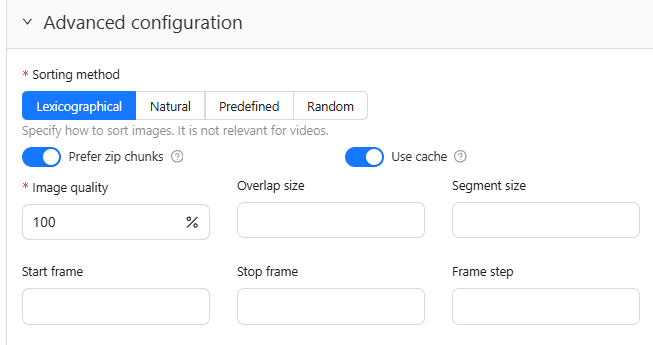

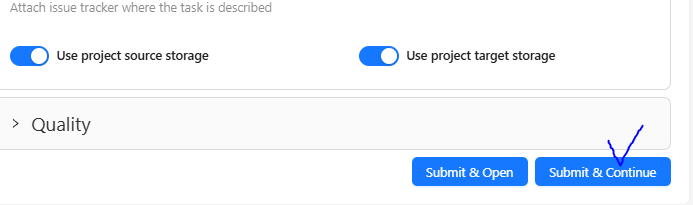

Continue 누르면 Project 탭에 아래처럼 뜰거임

### yolov7 배포
- 음 가끔씩 yolov8배포가 안될 수 있다 그럴때는 v7로 오토 돌리고 다시 v8로 돌리면 되기도 하니 이것도 모델 배포 해놓자